##Warstwa analityczna

###Background

- Moje rekomendacje zostały opracowane w kontekście implementacji Google Analytics 4 (GA4). W planie wdrożenia warstwy analitycznej zakładam jednoczesne uwzględnienie innych systemów analitycznych, takich jak Amplitude czy Mixpanel. Pozwoli to na przyspieszenie prac developerskich, zminimalizowanie ryzyka błędów wynikających z równoczesnej lub późniejszej integracji przez innych developerów oraz zapewnienie spójnej, standaryzowanej struktury śledzenia zdarzeń pomiędzy różnymi narzędziami.

- Ze względu na ograniczenia czasowe - część z rekomendacji może ulec modyfikacji kiedy będę miał możliwość dokładniejszej analizy witryny i zaproponowania zoptymalizowanej, długofalowej architektury analitycznej.

1.	Strona https://centrumrespo.pl/ posiada wiele elementów prowadzących do landing page ofertowych np. https://centrumrespo.pl/oferta/ przeznaczonej dla kobiet. W analizie zauważyłem, że jedynie w nielicznych przypadkach stosowany jest parametr umożliwiający identyfikację źródła ruchu `(int_source)`. Oznacza to, że w większości przypadków nie jesteśmy w stanie powiązać wizyt z konkretnymi miejscami kierującymi użytkowników na ofertę.
Przykład identyfikacji źródła na bannerze znajduje się tutaj:
https://centrumrespo.pl/dzieci/czy-dzieci-moga-pic-kawe/ => https://centrumrespo.pl/oferta/?int_source=baner-w-tresci&int_medium=baner-gorny&int_campaign=test-uniwersalne-banery-blog.

2. Przykład tagowania ruchu z zew.: https://centrumrespo.pl/oferta/?utm_source=YouTube&utm_medium=YT-MichalWrzosek&utm_campaign=06022025 gdzie utm_medium = YT-MichalWrzosek jest niepoprawne semantycznie – medium powinno oznaczać typ ruchu, a nie twórcę — można (i warto) go ulepszyć do takiej postaci: https://centrumrespo.pl/oferta/?utm_source=youtube&utm_medium=influencer&utm_campaign=michal_wrzosek_luty2025&utm_content=opis_filmu

2.	Obecnie na stronie rejestrowane są eventy oraz parametry niestandardowe (customowe), co nie jest optymalne w kontekście wymogów Google Analytics 4. Taka praktyka powoduje m.in.:

    - Ograniczoną użyteczność raportową w panelu GA4.
	- Niewykorzystanie dedykowanych pól w BigQuery, które umożliwiają łatwe i efektywne analizy danych.
    - Brak możliwości wykorzystania gotowych rozwiązań stworzonych przez społeczność, np. Google Marketing Solutions ( https://github.com/google-marketing-solutions ), GTM Templates, które są przygotowane zgodnie z najlepszymi praktykami nazewnictwa eventów i parametrów.
	- Ograniczenia w dodawaniu niestandardowych wymiarów i parametryzacji danych w przyszłości.

In [ ]:
~  Object:
{
	event: "stg.capturingClick",
	element: "A",
	elementId: "blog-offer-bottom",
	elementClasses: "v2-button isBlack cta",
	elementUrl: "https://centrumrespo.pl/oferta/?int_source=baner-w-tresci&int_medium=baner-gorny&int_campaign=test-uniwersalne-banery-blog"
}

###view_promotion

4.	Wszystkie elementy prowadzące do stron ofertowych powinny zostać zmapowane w warstwie danych (dataLayer). Zaleca się wdrożenie standardowego eventu w dataLayer, którego struktura umożliwi zarówno analizę granularną (po pojedynczych źródłach i kampaniach), jak i agregowaną (całościowy ruch na landing page).
Przykładowa struktura eventu:

In [ ]:
dataLayer.push({ ecommerce: null });  // Clear the previous ecommerce object.
dataLayer.push({
  event: "view_promotion", # Wyświtlenie elementu kierującego do ofery
  ecommerce: {
    creative_name: "Banner", # Banner, Button etc.
    creative_slot: "Dołącz do ponad 72 638 zadowolonych Podopiecznych!", # Nagłówek bannera, ułatwi interpretacje danych w BI
    promotion_id: "Dietetyka kliniczna", # Dzieci etc.
    promotion_name: "dietetyczka dziecięca • 7 sierpnia 2025 • 6 min czytania",
    uri_internal: "https://centrumrespo.pl/dzieci/neofobia-zywieniowa-u-dzieci/",
    uri_external: "https://centrumrespo.pl/oferta-kids/",
    source: "gad_source=1&gad_campaignid=22681743728&gbraid=0AAAAADDqrymispGDjRT7_ut72NeUwpVya&gclid=EAIaIQobChMI_MXK3LDEkAMVS6qDBx38pRM3EAAYAyAAEgIZSvD_BwE" # Przechowywane w local_storage lub indexed_db, jeśli brak parametrów to pusty string
  }
});

###select_promotion

In [ ]:
dataLayer.push({ ecommerce: null });  // Clear the previous ecommerce object.
dataLayer.push({
  event: "select_promotion", # Wyświtlenie elementu kierującego do ofery
  ecommerce: {
    creative_name: "Banner", # Banner, Button etc.
    creative_slot: "Dołącz do ponad 72 638 zadowolonych Podopiecznych!", # Nagłówek bannera, ułatwi interpretacje danych w BI
    promotion_id: "Dietetyka kliniczna", # Dzieci etc.
    promotion_name: "dietetyczka dziecięca • 7 sierpnia 2025 • 6 min czytania",
    uri_internal: "https://centrumrespo.pl/dzieci/neofobia-zywieniowa-u-dzieci/",
    uri_external: "https://centrumrespo.pl/oferta-kids/",
    source: "gad_source=1&gad_campaignid=22681743728&gbraid=0AAAAADDqrymispGDjRT7_ut72NeUwpVya&gclid=EAIaIQobChMI_MXK3LDEkAMVS6qDBx38pRM3EAAYAyAAEgIZSvD_BwE" # Przechowywane w local_storage, pusty string jeśli brak parametrów
  }
});

###view_item_list

5.	Strony ofertowe powinny wykorzystywać predefiniowany event E-Commerce w dataLayer, co umożliwi analizę zachowań użytkowników oraz integrację danych z procesem checkoutu. Obecnie checkout posiada zalążek eventów E-Commerce w dataLayer, dlatego wdrożenie spójnego standardu pozwoli na pełną analitykę ścieżki zakupowej od wejścia na ofertę po finalizację transakcji.
Przykładowa struktura eventu dla strony oferty (https://centrumrespo.pl/oferta/):

In [ ]:
dataLayer.push({ ecommerce: null });  // Clear the previous ecommerce object.
dataLayer.push({
  event: "view_item_list",
  ecommerce: {
    item_list_id: "Banner", # Jeżeli odsłona jest organiczna to wartość "no_internal_attribution"
    item_list_name: "Dołącz do ponad 72 638 zadowolonych Podopiecznych!", # Jeżeli odsłona jest organiczna to wartość "no_internal_attribution"
    items: [ # Wszystkie dane na poziomie items będą zmapowane zgodnie z charakterystykami, które znajdują się w bazie transakcyjnej. W pierwszej kolejności wykorzystam predefiniowane parametry.
     {
      item_id: "SKU_12345",
      item_name: "Stan and Friends Tee",
      affiliation: "Google Merchandise Store",
      coupon: "SUMMER_FUN",
      discount: 2.22,
      index: 0,
      item_brand: "Google",
      item_category: "Apparel",
      item_category2: "Adult",
      item_category3: "Shirts",
      item_category4: "Crew",
      item_category5: "Short sleeve",
      item_list_id: "related_products",
      item_list_name: "Related Products",
      item_variant: "green",
      location_id: "ChIJIQBpAG2ahYAR_6128GcTUEo",
      price: 10.03,
      quantity: 1,
      creative_name: "Banner", # Banner, Button etc.
      creative_slot: "Dołącz do ponad 72 638 zadowolonych Podopiecznych!", # Nagłówek bannera, ułatwi interpretacje danych w BI
      promotion_id: "Dietetyka kliniczna", # Dzieci etc.
      promotion_name: "dietetyczka dziecięca • 7 sierpnia 2025 • 6 min czytania",
      uri_internal: "https://centrumrespo.pl/dzieci/neofobia-zywieniowa-u-dzieci/",
      uri_external: "https://centrumrespo.pl/oferta-kids/",
      source: "gad_source=1&gad_campaignid=22681743728&gbraid=0AAAAADDqrymispGDjRT7_ut72NeUwpVya&gclid=EAIaIQobChMI_MXK3LDEkAMVS6qDBx38pRM3EAAYAyAAEgIZSvD_BwE" # Przechowywane w local_storage, pusty string jeśli brak parametrów,
      custom_params1: "women", # Modyfikacja oferty loguje nowy dl push
      custom_params2: "{{1. Wybierz rodzaj planu}}", # Modyfikacja oferty loguje nowy dl push
      custom_params3: "{{2. Określ czas współpracy}}", # Modyfikacja oferty loguje nowy dl push
      custom_params4: "{{payment: Subskrybuj i oszczędź1 20 zł *** etc.}}" # Modyfikacja oferty loguje nowy dl push

    },
    {
      item_id: "SKU_12345",
      item_name: "Stan and Friends Tee",
      affiliation: "Google Merchandise Store",
      coupon: "SUMMER_FUN",
      discount: 2.22,
      index: 1,
      item_brand: "Google",
      item_category: "Apparel",
      item_category2: "Adult",
      item_category3: "Shirts",
      item_category4: "Crew",
      item_category5: "Short sleeve",
      item_list_id: "related_products",
      item_list_name: "Related Products",
      item_variant: "green",
      location_id: "ChIJIQBpAG2ahYAR_6128GcTUEo",
      price: 10.03,
      quantity: 1,
      creative_name: "Banner", # Banner, Button etc.
      creative_slot: "Dołącz do ponad 72 638 zadowolonych Podopiecznych!", # Nagłówek bannera, ułatwi interpretacje danych w BI
      promotion_id: "Dietetyka kliniczna", # Dzieci etc.
      promotion_name: "dietetyczka dziecięca • 7 sierpnia 2025 • 6 min czytania",
      uri_internal: "https://centrumrespo.pl/dzieci/neofobia-zywieniowa-u-dzieci/",
      uri_external: "https://centrumrespo.pl/oferta-kids/",
      source: "gad_source=1&gad_campaignid=22681743728&gbraid=0AAAAADDqrymispGDjRT7_ut72NeUwpVya&gclid=EAIaIQobChMI_MXK3LDEkAMVS6qDBx38pRM3EAAYAyAAEgIZSvD_BwE" # Przechowywane w local_storage, pusty string jeśli brak parametrów,
      custom_params1: "women", # Modyfikacja oferty loguje nowy dl push
      custom_params2: "{{1. Wybierz rodzaj planu}}", # Modyfikacja oferty loguje nowy dl push
      custom_params3: "{{2. Określ czas współpracy}}", # Modyfikacja oferty loguje nowy dl push
      custom_params4: "{{payment: Subskrybuj i oszczędź1 20 zł *** etc.}}" # Modyfikacja oferty loguje nowy dl push
    }]
  }
});

###Analiza aktualnej warstwy analitycznej w checkout

6. Obecna implementacja warstwy dataLayer w procesie checkout wymaga optymalizacji, aby spełniała standardy predefiniowanych eventów E-Commerce w GA4:
    - Event `begin_checkout` wywoływany jest dopiero na drugim kroku checkoutu. Powinien być uruchamiany na pierwszym kroku, przed przejściem do kolejnych etapów, aby poprawnie śledzić rozpoczęcie procesu zakupowego.
    - Dodawanie dodatkowych usług w koszyku (https://centrumrespo.pl/koszyk/) nie jest rejestrowane przez event `add_to_cart`, co powoduje brak pełnej informacji o zachowaniach użytkowników i ogranicza możliwości analityczne.
    - Aktualnie `add_to_cart` wywołuje się dopiero po przeładowaniu koszyka (po zalogowaniu event `view_cart`). Każde przeładowanie strony generuje kolejne logowanie `add_to_cart`, co powoduje, że liczba dodanych produktów jest sztucznie zawyżana i nie odzwierciedla rzeczywistego zachowania użytkownika. Event powinien być rejestrowany w momencie faktycznego dodania oferty przed przeładowaniem strony.






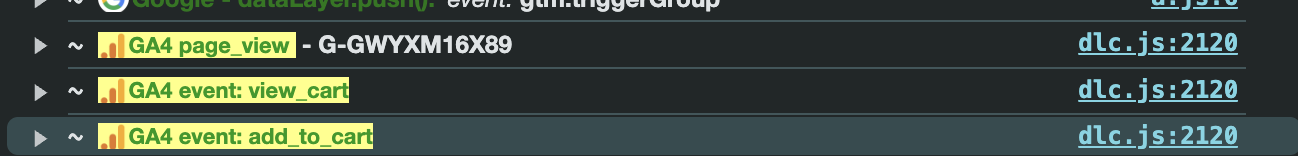

In [ ]:
	sid: "1761648248", # Brak parametrów items wynika z braku dL push
	sct: "6",
	seg: "1",
	dl: "https://centrumrespo.pl/koszyk/",
	dr: "https://centrumrespo.pl/koszyk/",
	dt: "Koszyk - Centrum Respo",
	_tu: "CA",
	en: "view_cart",
	_c: "1",
	gap.plf: "woo",
	_et: "1",
	tfd: "802"

In [ ]:
~  Object:
{
	eventID: "7b3962a9-2af2-4a2c-9012-3af5a70f1080",
	event_id: "7b3962a9-2af2-4a2c-9012-3af5a70f1080",
	event: "InitiateCheckoutNew",
	source: "",
	value: 1077,
	currency: "PLN",
	content_type: "product",
	content_category: "respo",
	content_ids: [
		480608
	],
	content_name: "",
	contents: [
		{
			id: 480608,
			quantity: 1,
			price: 1077,
			content_type: "product",
			content_category: "respo",
			content_id: "480608",
			content_name: "Dieta i trening Vip - 3 miesiące [packageV3]"
		}
	],
	items: [
		{
			item_id: 480608,
			item_name: "Dieta i trening Vip - 3 miesiące",
			index: 0,
			price: 1077,
			quantity: 1
		}
	],

###Pozostałe predefiniowane eventy

7. Struktura pozostałych eventów na ścieżce do zakupu eventów będzie zbliżona do eventu `view_item_list` z drobnymi zmianami np. dodanie `coupon`, `payment_type`.

    - `add_to_cart` – rejestruje dodanie produktu lub usługi do koszyka w momencie faktycznego kliknięcia, przed przeładowaniem strony. Powinien zawierać pełne informacje o produkcie oraz ewentualny kupon.
    - `view_cart` (https://centrumrespo.pl/koszyk/) – uruchamiany przy wejściu do koszyka, pokazuje bieżącą zawartość koszyka i sumaryczne wartości produktów.
    - `begin_checkout` (https://centrumrespo.pl/koszyk/) – wywoływany po kliknięciu przycisku „Dalej” w koszyku, rozpoczynający proces checkout. Powinien przekazywać informacje o wszystkich produktach w koszyku oraz dodatkowe parametry, np. coupon.
    - `add_payment_info` (https://centrumrespo.pl/zamowienie/) – rejestrowany po wyborze metody płatności i kliknięciu „Subskrybuję i płacę”. Powinien zawierać typ płatności (payment_type) oraz dane o koszyku i ewentualnym kuponie.
    - `purchase` – finalizuje zakup, rejestrując wszystkie informacje o transakcji, produkty, kwoty, walutę, zastosowane rabaty i typ płatności.

8. Rejestracja transakcji przed i po przetworzeniu płatności. Aby zapewnić pełną kontrolę nad ścieżką zakupową i umożliwić implementację rozwiązań typu `Enhanced Conversions w Google Ads oraz CAPI w Meta`, rekomenduje się dwustopniowe rejestrowanie zdarzenia purchase:

    - Purchase przed przetworzeniem płatności
        - Event `purchase` wywoływany w momencie przed przekazaniem danych do bramki płatności.
        - Parametr dodatkowy: `status = 'before_payment'`.
	    - Rejestracja pozwala analizować porzucenia koszyka i efektywność checkoutu przed płatnością.
    - Purchase po udanej transakcji
        - Event `purchase` wywoływany po potwierdzeniu płatności.
        - Parametr dodatkowy: `status = 'success'`.
        - W tym eventcie dodawane są dane klienta wymagane do `Enhanced Conversions i CAPI, np.: email, first_name, last_name, phone`.
        - Wszystkie dane osobowe powinny być haszowane SHA256 przed wysłaniem do systemów reklamowych, zapewniając zgodność z wymogami prywatności i ochrony danych.
        - Event zawiera pełną informację o transakcji: produkty, kwoty, walutę, zastosowane rabaty oraz typ płatności.

    - Rekomendacja: dwustopniowe podejście pozwala nie tylko na monitorowanie porzuceń i skuteczności checkoutu, ale także umożliwia prawidłowe i bezpieczne przesyłanie danych do platform reklamowych w celu poprawy konwersji i raportowania atrybucji.

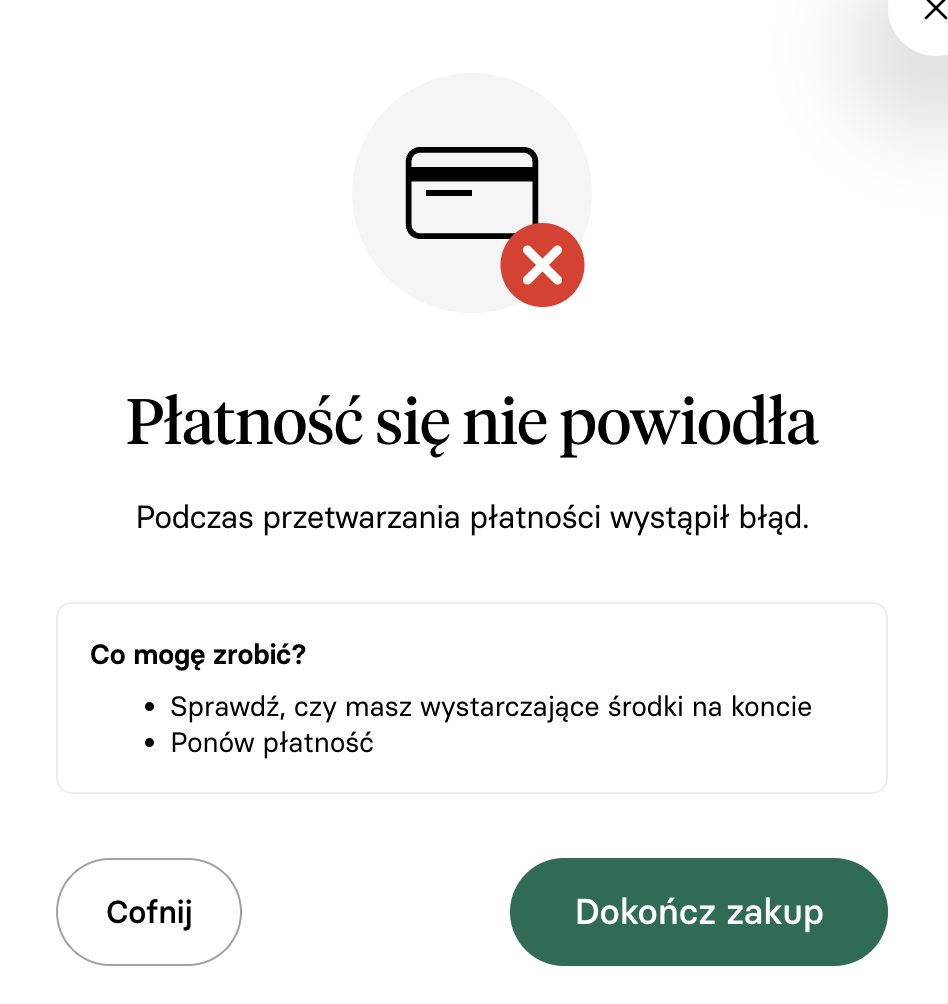

9. Dodatkowe eventy customowe w checkout. Po wdrożeniu podstawowej warstwy E-Commerce (punkty 1–8), warto rozważyć dodanie dodatkowych, niestandardowych eventów w `checkout`, które pozwolą na pogłębioną analizę zachowań użytkowników oraz optymalizację konwersji. Rekomendowane przykłady:
    - Metody płatności
        - Event `select_payment_method`.
        - Rejestracja wyboru płatności (np. karta, BLIK, przelew) pozwala analizować popularność metod i porzucenia na tym etapie.
    - Formularze checkout
        - Eventy typu `form_field_focus, form_field_complete lub form_error`.
        - Rejestracja interakcji z każdym polem formularza umożliwia identyfikację trudnych lub mylących elementów oraz punktów porzucenia.
    - Analiza zachowań użytkownika
        - Eventy wynikające z analizy nagrań sesji, np. `checkout_scroll_depth, hover_over_info, back_button_click`.
        - Pozwalają ocenić trudności w nawigacji i wypełnianiu checkoutu.
    - Integracja danych jakościowych
        - Wykorzystanie zgłoszeń z BOK oraz danych z narzędzi analityki formularzy (np. Zuko) do identyfikacji problematycznych etapów.
        - Eventy niestandardowe mogą być tagowane odpowiednimi kategoriami błędów lub wyzwań (np. `missing_field, validation_error`).

    - Rekomendacja: Dzięki wprowadzeniu takich eventów możliwe jest:
        - optymalizowanie checkoutu w oparciu o twarde dane i obserwacje jakościowe,
        - segmentowanie użytkowników według problemów lub preferencji,
        - testowanie zmian w formularzu i płatnościach w eksperymentach A/B.

#Coffee break

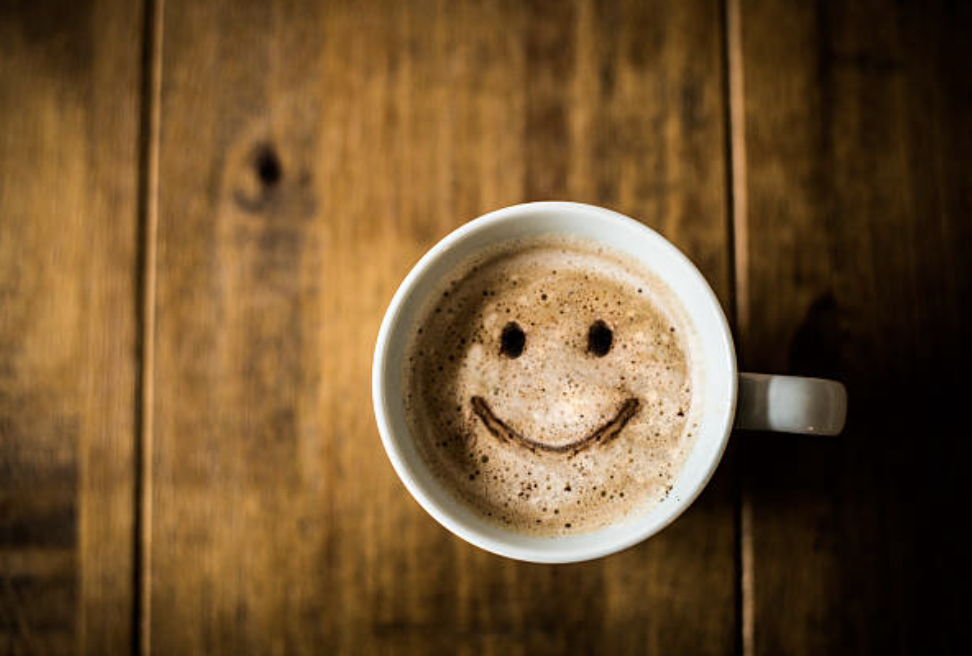

#Analiza syntetycznych danych

In [ ]:
!pip install google-cloud-bigquery

In [ ]:
import pandas as pd
from google.cloud import bigquery

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/big-query.json"

###0. Próbka tabeli.

In [ ]:
client = bigquery.Client()

query = """
SELECT *
FROM `pro-variety-473912-k5.centrumrespo.diet_events`
LIMIT 10;
"""

query_job = client.query(query)
results = query_job.result()

df = client.query(query).to_dataframe()
print(df)

   UserID             EventDatetime  MealID  RecipeID Status
0      35 2025-09-23 20:52:21+00:00       5        75  eaten
1      34 2025-09-08 20:25:22+00:00       5        79  eaten
2     180 2025-09-12 19:33:31+00:00       5        79  eaten
3     314 2025-09-01 22:58:32+00:00       2       100  eaten
4     493 2025-09-02 10:45:32+00:00       2       100  eaten
5     259 2025-09-02 17:05:45+00:00       4       100  eaten
6     456 2025-09-03 14:23:10+00:00       3       100  eaten
7     490 2025-09-04 08:21:37+00:00       1       100  eaten
8     355 2025-09-04 13:32:33+00:00       3       100  eaten
9     123 2025-09-05 19:07:40+00:00       5       100  eaten


###1. Ile posiłków zostało zjedzonych, a ile pominiętych w analizowanym okresie?


In [ ]:
client = bigquery.Client()

query = """
SELECT
  Status,
  COUNT(*) AS meals_count,
  ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS share_percent
FROM `pro-variety-473912-k5.centrumrespo.diet_events`
GROUP BY Status
ORDER BY meals_count DESC;
"""

df = client.query(query).to_dataframe()
print(df)

    Status  meals_count  share_percent
0  skipped        34849          64.58
1    eaten        19115          35.42


W analizowanym okresie użytkownicy `zjedli 35,42%` wszystkich zaplanowanych posiłków, natomiast `aż 64,58% zostało pominiętych`. Wskazuje to na dość niski poziom realizacji planu żywieniowego — ponad połowa posiłków nie jest konsumowana, co może oznaczać problem z motywacją, dopasowaniem planu do stylu życia lub dostępnością produktów.

###2. Które przepisy `RecipeID` są pomijane najczęściej, a które są najczęściej oznaczane jako zjedzone?

In [ ]:
client = bigquery.Client()

query = """
WITH recipe_summary AS (
  SELECT
    RecipeID,
    COUNTIF(Status = 'eaten') AS eaten_count,
    COUNTIF(Status = 'skipped') AS skipped_count,
    COUNT(*) AS total_count
  FROM `pro-variety-473912-k5.centrumrespo.diet_events`
  GROUP BY RecipeID
),

recipe_with_shares AS (
  SELECT
    RecipeID,
    eaten_count,
    skipped_count,
    total_count,
    ROUND(eaten_count / total_count * 100, 2) AS eaten_share_pct,
    ROUND(skipped_count / total_count * 100, 2) AS skipped_share_pct
  FROM recipe_summary
)

SELECT
  RecipeID,
  eaten_count,
  skipped_count,
  total_count,
  eaten_share_pct,
  skipped_share_pct,
  RANK() OVER (ORDER BY total_count DESC) AS popularity_rank
FROM recipe_with_shares
ORDER BY total_count DESC
LIMIT 20;
"""

df = client.query(query).to_dataframe()
print(df)

    RecipeID  eaten_count  skipped_count  total_count  eaten_share_pct  \
0        568         7859          14182        22041            35.66   
1       1118         6516          11889        18405            35.40   
2        673         2785           5250         8035            34.66   
3        134         1353           2463         3816            35.46   
4        349          105            186          291            36.08   
5        967           94            156          250            37.60   
6        471           56            119          175            32.00   
7        173           51             82          133            38.35   
8        146           46             78          124            37.10   
9        100           42             65          107            39.25   
10       572           21             35           56            37.50   
11      1479           17             29           46            36.96   
12       968           14             

Na podstawie danych widać, że `najczęściej pomijane przepisy to RecipeID 568, 1118 i 673`, dla których udział pominięć przekracza 64% wszystkich przypadków. Oznacza to, że te przepisy mogą być mniej atrakcyjne smakowo, wizualnie lub trudniejsze do przygotowania.

Z kolei `najchętniej spożywane przepisy to RecipeID 1493, 1243 i 1363`, z udziałem zjedzonych posiłków powyżej 40%, co sugeruje, że te dania są lepiej dopasowane do preferencji użytkowników lub łatwiejsze w realizacji w codziennej diecie. Przy czym są to wartości względne (mała skala liczb).

###3. Które posiłki `MealID` są pomijane najczęściej?

In [ ]:
client = bigquery.Client()

query = """
WITH meal_summary AS (
  SELECT
    MealID,
    COUNTIF(Status = 'eaten') AS eaten_count,
    COUNTIF(Status = 'skipped') AS skipped_count,
    COUNT(*) AS total_count
  FROM `pro-variety-473912-k5.centrumrespo.diet_events`
  GROUP BY MealID
),

meal_with_shares AS (
  SELECT
    MealID,
    eaten_count,
    skipped_count,
    total_count,
    ROUND(eaten_count / total_count * 100, 2) AS eaten_share_pct,
    ROUND(skipped_count / total_count * 100, 2) AS skipped_share_pct
  FROM meal_summary
)

SELECT
  MealID,
  skipped_count,
  eaten_count,
  total_count,
  skipped_share_pct,
  eaten_share_pct,
  RANK() OVER (ORDER BY skipped_share_pct DESC) AS skip_rank
FROM meal_with_shares
ORDER BY skipped_share_pct DESC;
"""

df = client.query(query).to_dataframe()
print(df)

   MealID  skipped_count  eaten_count  total_count  skipped_share_pct  \
0       4           8714         2010        10724              81.26   
1       2           8532         2375        10907              78.22   
2       3           5980         4818        10798              55.38   
3       1           5883         4920        10803              54.46   
4       5           5740         4992        10732              53.48   

   eaten_share_pct  skip_rank  
0            18.74          1  
1            21.78          2  
2            44.62          3  
3            45.54          4  
4            46.52          5  


Na podstawie wyników można zauważyć, że `najczęściej pomijane są posiłki oznaczone jako MealID 4 i 2`, z udziałem pominięć odpowiednio 81,26% i 78,22% wszystkich przypadków. Oznacza to, że użytkownicy najczęściej rezygnują z tych posiłków, co może sugerować problemy z ich dopasowaniem do pory dnia, objętości lub atrakcyjności przepisu.

Z kolei `MealID 5 ma najwyższy odsetek zjedzonych posiłków`, co może wskazywać, że użytkownicy chętniej spożywają późniejsze lub końcowe dania dnia.

###4. Dodatkowa obserwacja (dane syntetyczne) - sticky

https://docs.google.com/spreadsheets/d/1NqiCvnfoZHLougsXPcubOXlx-Wk6LFxG/edit?gid=1533960916#gid=1533960916


In [ ]:
client = bigquery.Client()

query = """
WITH per_user_recipe AS (
  SELECT
    RecipeID,
    UserID,
    COUNTIF(Status = 'eaten') AS liczba_zjedzen_uzytkownika,
    COUNT(*) AS liczba_wyswietlen_uzytkownika
  FROM `pro-variety-473912-k5.centrumrespo.diet_events`
  GROUP BY RecipeID, UserID
),

podsumowanie_przepisu AS (
  SELECT
    RecipeID,
    SUM(liczba_zjedzen_uzytkownika) AS laczna_liczba_zjedzen,
    SUM(liczba_wyswietlen_uzytkownika) AS laczna_liczba_wyswietlen,
    COUNT(DISTINCT UserID) AS liczba_unikalnych_uzytkownikow_widzialo,
    COUNTIF(liczba_zjedzen_uzytkownika > 0) AS liczba_unikalnych_uzytkownikow_zjadlo,
    COUNTIF(liczba_zjedzen_uzytkownika > 1) AS liczba_unikalnych_uzytkownikow_powtorzylo
  FROM per_user_recipe
  GROUP BY RecipeID
)

SELECT
  *
FROM podsumowanie_przepisu
WHERE laczna_liczba_wyswietlen >= 30
order by liczba_unikalnych_uzytkownikow_powtorzylo desc
"""

df = client.query(query).to_dataframe()
print(df)

    RecipeID  laczna_liczba_zjedzen  laczna_liczba_wyswietlen  \
0        568                   7859                     22041   
1       1118                   6516                     18405   
2        673                   2785                      8035   
3        134                   1353                      3816   
4        349                    105                       291   
5        967                     94                       250   
6        173                     51                       133   
7        471                     56                       175   
8        100                     42                       107   
9        146                     46                       124   
10       968                     14                        37   
11       572                     21                        56   
12      1243                     13                        31   
13      1479                     17                        46   

    liczba_unikalnych_uz

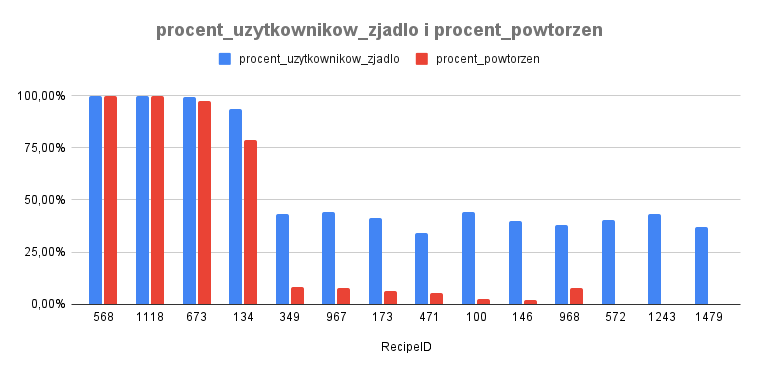

Na podstawie dostarczonych syntetycznych wyników widać wyraźnie, że tylko kilka przepisów `(np. RecipeID 568, 1118, 673, 134)` dominuje wśród użytkowników — są najczęściej wybierane i najczęściej powtarzane, z współczynnikiem powtórzeń powyżej 95%. To oznacza, że użytkownicy bardzo chętnie do nich wracają, co wskazuje na ich wysoki poziom akceptacji i potencjalnie kluczową rolę w utrzymaniu zaangażowania klientów. Pozostałe przepisy mają znacznie niższy wskaźnik powtarzalności (poniżej 10%), co może świadczyć o mniejszym dopasowaniu do preferencji użytkowników, trudności w przygotowaniu lub niskiej atrakcyjności smakowej.

W ujęciu produktowym oznacza to, że warto zidentyfikować cechy przepisów o wysokiej powtarzalności – np. składniki, kaloryczność, poziom trudności – i wykorzystać je jako wzór przy tworzeniu nowych propozycji. Można także promować te najczęściej powtarzane przepisy w aplikacji jako „ulubione społeczności” lub „sprawdzone i lubiane”.

Z perspektywy marketingowej, przepisy z wysokim wskaźnikiem powtórzeń można wykorzystać w kampaniach retencyjnych, np. przypominać użytkownikom o ich ulubionych potrawach lub proponować podobne dania w newsletterach i powiadomieniach push. Warto również przeanalizować użytkowników, którzy nie powtarzają żadnych przepisów – może to wskazywać na niskie zaangażowanie lub problem z personalizacją planu żywieniowego.

Podsumowując: dane sugerują istnienie kilku kluczowych „magnesów retencyjnych” w postaci popularnych przepisów, które należy pielęgnować i komunikować szerzej. Jednocześnie wskazane jest zoptymalizowanie pozostałych przepisów lub zastąpienie ich wariantami inspirowanymi tymi najczęściej wybieranymi.

#Gratis dla PO aplikacji - Benchmark jakościowy — App Store vs Google Play

Analiza negatywnych opinii z obu sklepów ujawnia dużą spójność problemów produktowo-operacyjnych (stabilność, logowanie, personalizacja, obsługa klienta). Różnice dotyczą skali emocji/tonu oraz nacisku na cenę i brak wersji próbnej — co wskazuje, że problemy są techniczno-procesowe, a ich skutki nasilają się inaczej w obu kanałach.

https://docs.google.com/spreadsheets/d/1F4Mg3899qQXP8gFaQwzxxxgu1AAS233I/edit?gid=1621875138#gid=1621875138

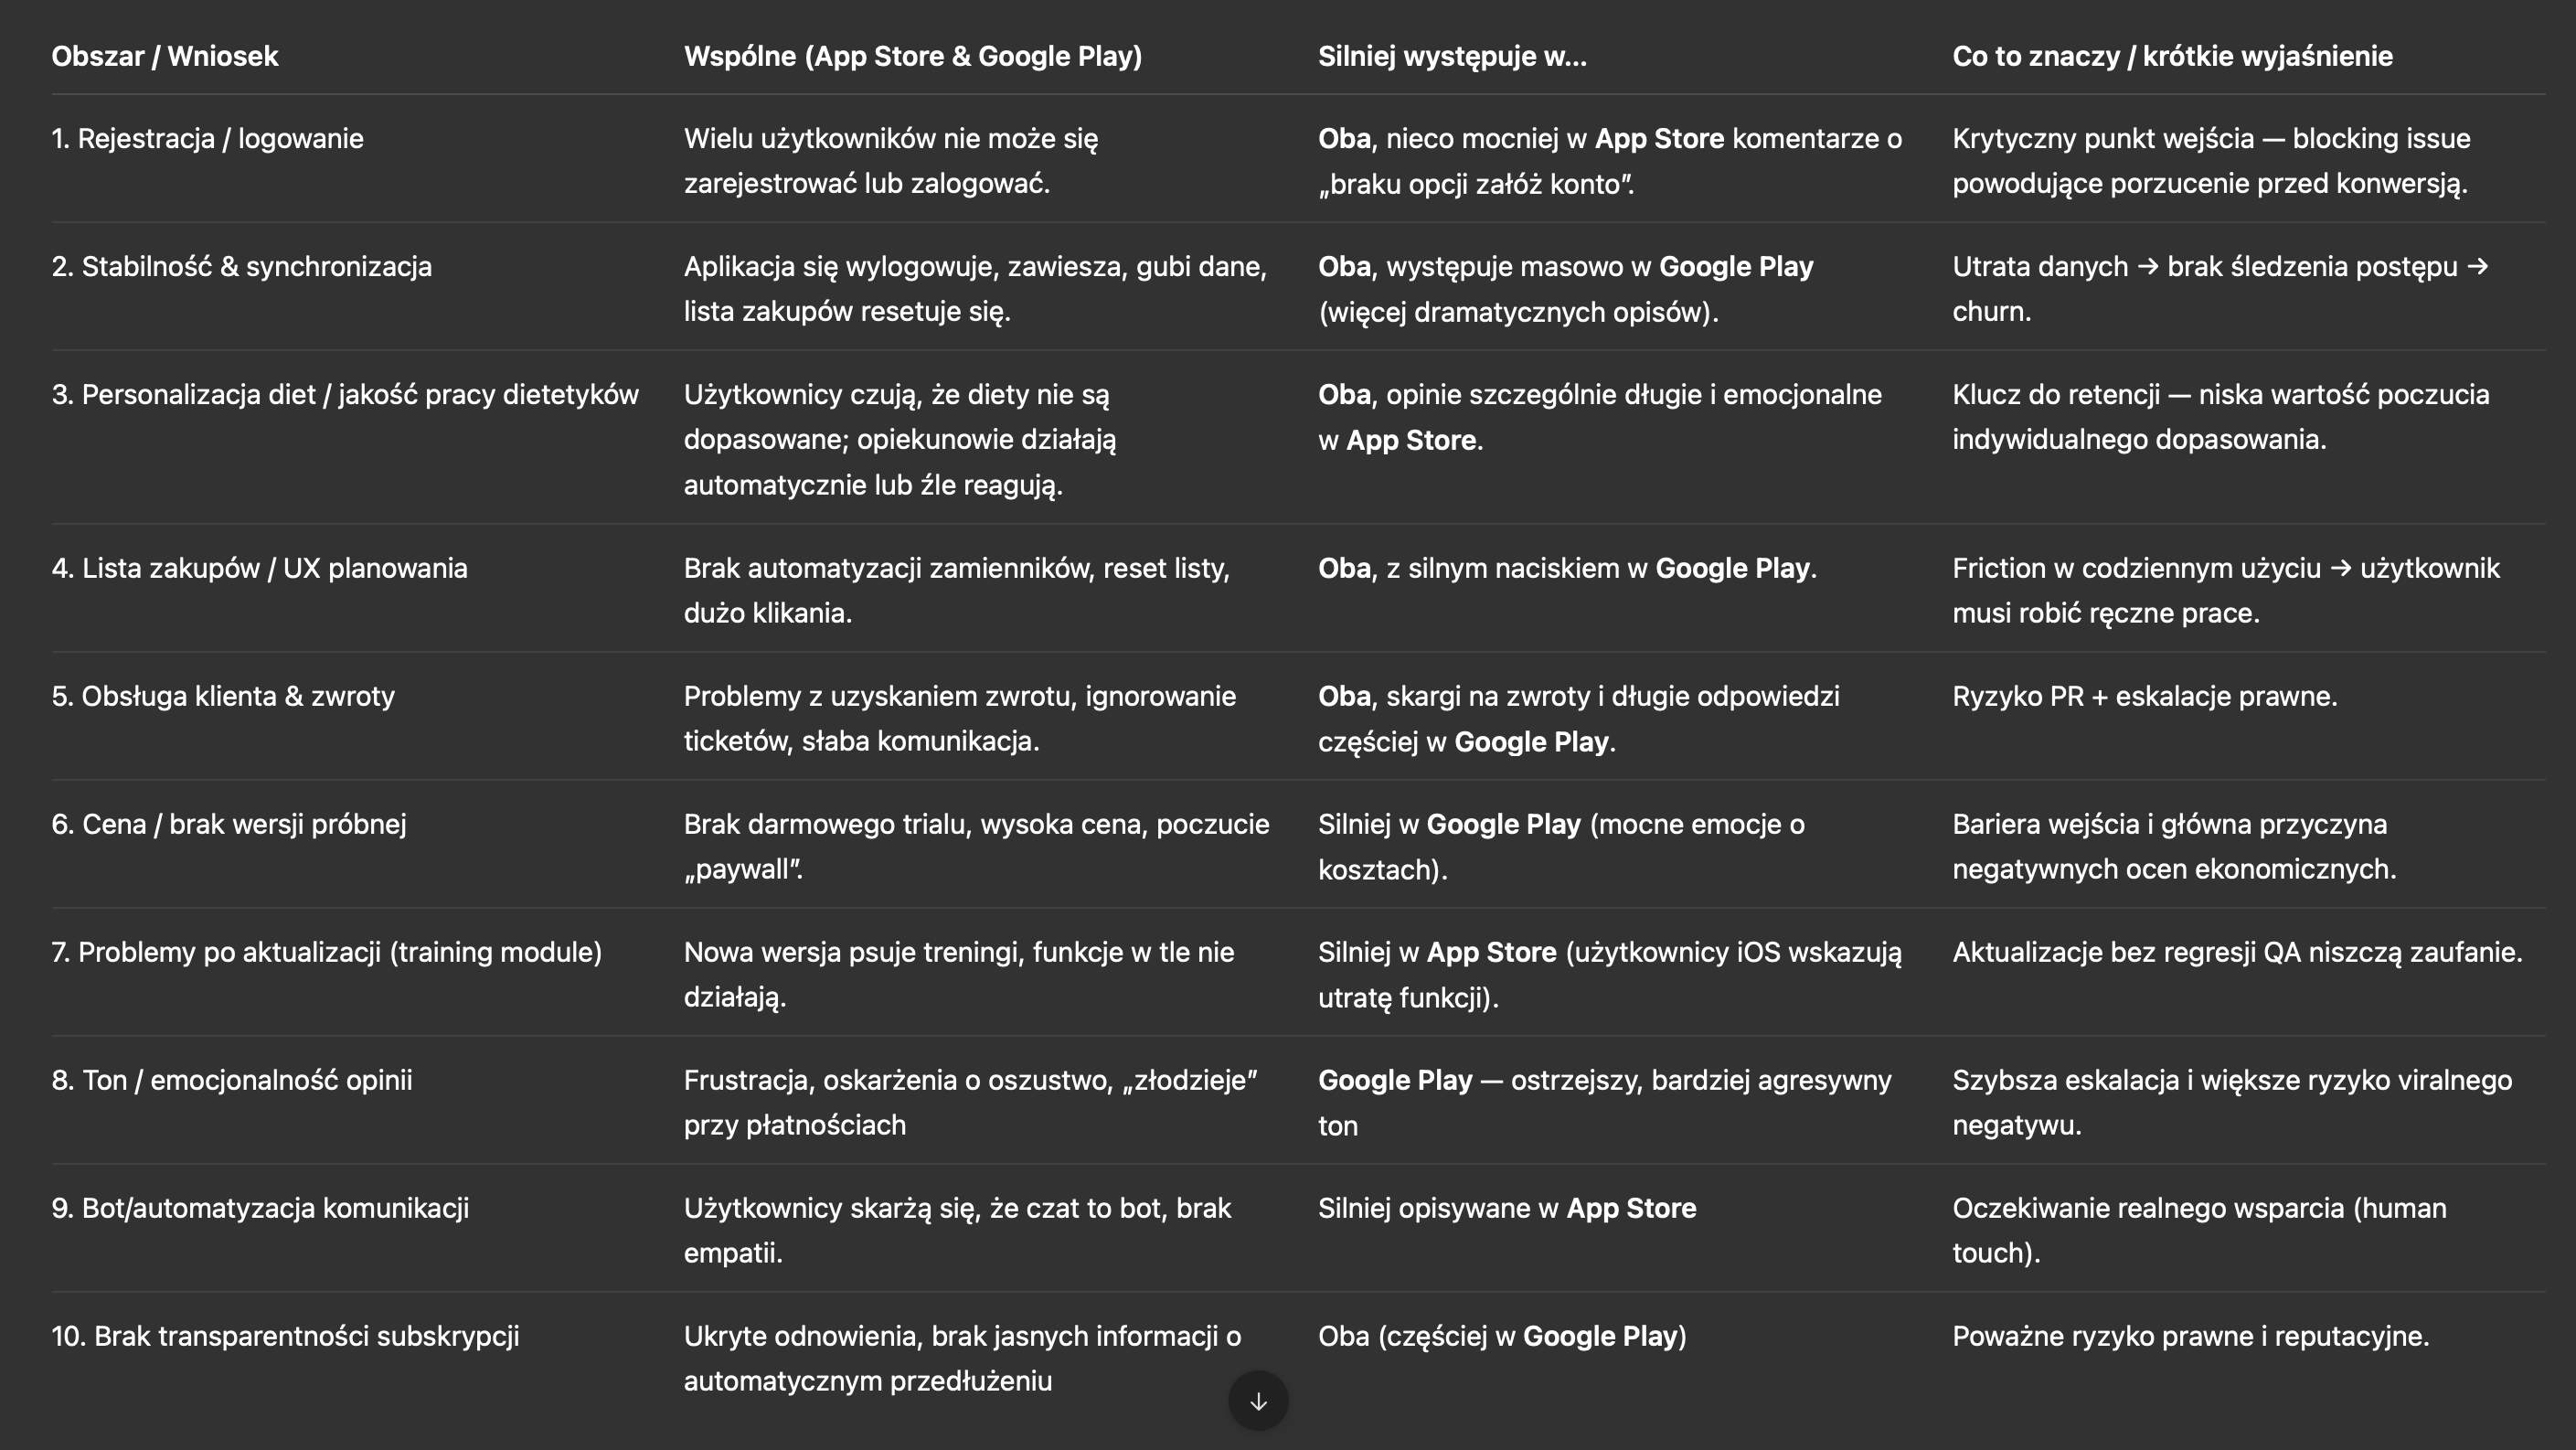






#Eksperymenty z Chrome DevTools MCP - UX / CRO

##Najważniejsze stwierdzenia
1. MCP to otwarty standard, zapoczątkowany przez Anthropic, mający na celu połączenie LLM z zewnętrznymi danymi i narzędziami.  ￼
2. MCP rozwiązuje problem „N x M integrations” — integrujesz narzędzie raz, a wiele modeli może z niego korzystać.  ￼
3. Amplitude i inne firmy udostępniają MCP-serwery (np. Amplitude MCP) zamiast budować własne LLM.  ￼
4. Chrome DevTools MCP istnieje i pokazuje jak narzędzia z UI (przeglądarka/DevTools) mogą być expose’owane jako MCP-serwery.  ￼
5. Istnieją realne incydenty bezpieczeństwa związane z MCP / supply-chain (złośliwy pakiet MCP potrafił kraść e-maile) — trzeba traktować bezpieczeństwo poważnie.  ￼


Świetnie — zaczynamy profesjonalną **ekspertyzę CRO (Conversion Rate Optimization)** oraz **UX (User Experience)** dla strony [Centrum Respo — Oferta](https://centrumrespo.pl/oferta/).
Przeanalizuję ją **pod kątem zwiększenia konwersji na zakup subskrypcji** (czyli „Zamawiam subskrypcję” lub „Zamów dietę”).

Na tym etapie przygotuję **część 1: audyt diagnostyczny** — czyli dokładną analizę struktury, psychologii decyzji, hierarchii informacji, barier i potencjalnych punktów tarcia (friction points).
Po Twoim potwierdzeniu przygotuję **część 2: konkretne rekomendacje optymalizacyjne i hipotezy testów A/B**.

---

## 🧭 CZĘŚĆ 1: DIAGNOSTYKA STRONY OFERTY CENTRUM RESPO

### 1. Kontekst i cel biznesowy

* **Cel makro:** zakup subskrypcji (Standard / Premium / VIP).
* **Cele mikro:** kliknięcia w CTA („Sprawdź ofertę”, „Zamawiam pakiet”, „Porównaj pakiety”), przewinięcia strony, wybór pakietu.
* **Produkt:** plan dietetyczno-treningowy z opcją opieki online, personalizacji i aplikacji mobilnej.
* **Grupa docelowa:** kobiety 25–45 lat, zainteresowane zdrowym stylem życia, redukcją masy ciała i poprawą samopoczucia.

---

### 2. Pierwsze wrażenie i above the fold (hero section)

| Element                                                                    | Ocena        | Opis                                                                                                           |
| -------------------------------------------------------------------------- | ------------ | -------------------------------------------------------------------------------------------------------------- |
| **Headline („Nasz dietetyk online przygotuje idealną dla Ciebie dietę.”)** | ✅ Dobry      | Jasny komunikat korzyści, ale **brakuje konkretnego wyróżnika** (np. liczby użytkowników, efektów, gwarancji). |
| **Subheadline („Z nami schudniesz bez wyrzeczeń…”)**                       | ⚠️ Średni    | Język emocjonalny, lecz mało konkretny. Warto wzmocnić dowodem społecznym lub efektem liczbowym.               |
| **CTA („Sprawdź ofertę”)**                                                 | ⚠️ Słaby     | Zbyt ogólny, **nie kieruje bezpośrednio do zakupu** (lepszy byłby „Rozpocznij dietę” lub „Zamów swój plan”).   |
| **Dowody społeczne (oceny z Google, App Store, Facebook)**                 | ✅ Mocny      | Liczne, wizualnie spójne, wzmacniają zaufanie. Można jednak połączyć je w jeden, bardziej czytelny moduł.      |
| **Elementy rozpraszające (grafiki, zmieniające się zdjęcia)**              | ❌ Zbyt wiele | Animacje i wielokrotne slajdy konkurują o uwagę z CTA, co **rozmywa ścieżkę konwersji**.                       |

**Diagnoza:** pierwsze 10 sekund nie prowadzi jednoznacznie do akcji.
➡️ **Cel emocjonalny (motywacja)** jest silny, ale **cel behawioralny (kliknięcie CTA)** jest rozproszony.

---

### 3. Struktura i flow strony

| Aspekt                                                       | Ocena                  | Komentarz                                                                                                                               |
| ------------------------------------------------------------ | ---------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| **Kolejność sekcji**                                         | ⚠️ Długa i powtarzalna | Strona zawiera bardzo dużo treści — typowa struktura „long-form sales page”, ale **brak mocnych kotwic CTA** co 1–2 sekcje.             |
| **Scroll-depth logic**                                       | ❌                      | CTA nie są logicznie rozmieszczone (często znikają z pola widzenia). Brakuje „sticky CTA” lub paska postępu.                            |
| **Segmentacja odbiorców (kobiety, mężczyźni, pary, dzieci)** | ✅                      | Dobrze, że istnieje — ale na stronie głównej oferty **lepiej kierować do wyboru persony po wstępnym zainteresowaniu**, nie od razu.     |
| **Czytelność porównania pakietów**                           | ⚠️                     | Dane są kompletne, ale **tabela jest bardzo długa i męcząca poznawczo**. Użytkownik gubi różnice między Premium i VIP.                  |
| **Wyróżnienie najlepszego pakietu (Premium)**                | ✅                      | Jest badge „Najczęściej wybierany” + badanie sprzedaży, ale **brakuje wizualnego kontrastu kolorystycznego** (CTA mają podobny wygląd). |

---

### 4. Psychologia decyzji i heurystyki

| Heurystyka                                           | Status   | Komentarz                                                                                                                |
| ---------------------------------------------------- | -------- | ------------------------------------------------------------------------------------------------------------------------ |
| **Społeczny dowód słuszności (social proof)**        | ✅ Silny  | Opinie, liczby sukcesów, metamorfozy — bardzo dobrze.                                                                    |
| **Zaufanie / bezpieczeństwo (trust signals)**        | ✅        | SSL, metody płatności, gwarancja 7 dni, logotypy – profesjonalne.                                                        |
| **Niedostępność / pilność (scarcity, urgency)**      | ⚠️ Słaba | Licznik „Zamów dziś, otrzymaj plan 07.11” jest słaby psychologicznie — **brakuje emocji i personalizacji**.              |
| **Wyróżnienie wartości (value proposition clarity)** | ⚠️       | Trzy pakiety mają podobne korzyści – **trudno wybrać**. Nie widać szybko „co dostaję więcej w Premium / VIP”.            |
| **Koszt alternatywny / decoy effect**                | ❌        | Nie wykorzystano tzw. *decoy pricing*. Użytkownik może nie zrozumieć, że Premium ma najlepszy stosunek wartości do ceny. |

---

### 5. Elementy techniczne i UX

| Obszar                        | Ocena | Wnioski                                                                                                                        |
| ----------------------------- | ----- | ------------------------------------------------------------------------------------------------------------------------------ |
| **Szybkość i wydajność**      | ⚠️    | Dużo obrazów, potencjalnie wysokie LCP. Wersja mobilna może być wolna.                                                         |
| **Wersja mobilna**            | ⚠️    | Przy takiej długości strony – **brak sticky CTA** znacząco obniża konwersję.                                                   |
| **Formularz zakupowy**        | ✅     | Krótki, przejrzysty (przechodzi przez WooCommerce).                                                                            |
| **Kontekst CTA (mikrokopii)** | ❌     | Wszystkie przyciski są zbyt ogólne – brak personalizacji i języka decyzji („Chcę schudnąć z Respo”, „Zamawiam dietę Premium”). |

---

### 6. Potencjalne punkty tarcia (friction points)

| Obszar                                           | Problem                                    | Potencjalny wpływ                            |
| ------------------------------------------------ | ------------------------------------------ | -------------------------------------------- |
| Przeciążenie informacyjne                        | Zbyt dużo tekstu i sekcji porównawczych    | Spadek konwersji o 15–30%                    |
| Niejasne różnice między pakietami                | Premium i VIP wyglądają niemal identycznie | Decyzyjny paraliż (paradox of choice)        |
| Brak przewodnika po procesie                     | Nie ma wizualizacji 3 kroków zakupu        | Brak poczucia prostoty / klarowności procesu |
| CTA nie utrzymuje się w zasięgu wzroku           | Brak sticky CTA lub floating button        | Użytkownicy mobilni mogą nie dojść do końca  |
| Zbyt ogólne komunikaty CTA                       | „Sprawdź ofertę” nie komunikuje wartości   | Niski CTR                                    |
| Brak personalizacji oferty (np. quizu wstępnego) | Brak angażującego elementu                 | Słabsza konwersja top-of-funnel              |

---

## 📊 Wstępna ocena konwersyjności (0–10)

| Obszar                                 | Ocena  | Opis                                                        |
| -------------------------------------- | ------ | ----------------------------------------------------------- |
| UX (przejrzystość, hierarchia, flow)   | 7/10   | Dobrze zaprojektowana wizualnie, ale poznawczo przeciążona. |
| CTA i copywriting konwersyjny          | 6/10   | Zbyt generyczny język, mało wezwań do działania.            |
| Psychologia decyzji (heurystyki)       | 7.5/10 | Dobre podstawy, ale brak wyraźnego „momentu decyzji”.       |
| Zaufanie / dowody społeczne            | 9/10   | Bardzo mocne i autentyczne.                                 |
| Perswazyjność oferty (wartość vs cena) | 6/10   | Brak decoy pricing i mocnych kontrastów.                    |

➡️ **Średnia ocena CRO: 7/10 (duży potencjał optymalizacyjny).**






## 🔍 CEL

👉 Zwiększenie liczby użytkowników, którzy **dodają pakiet do koszyka** lub **kupują subskrypcję** (Standard / Premium / VIP).

---

## 1. 🔄 STRUKTURA STRONY – PROPOZYCJE ZMIAN

| Obszar                                           | Problem UX/CRO                                                                                                                | Rekomendacja / Test                                                                                                                                          |
| ------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Sekcja hero („Nasz dietetyk online…”)**        | Tekst ma niski kontrast i nie zawiera jasnej wartości użytkownika (brak silnego CTA).                                         | Test A/B: wariant nagłówka z konkretnym wynikiem („Schudnij do 5 kg w 30 dni z dietetykiem online”) + CTA „Rozpocznij bez ryzyka” powyżej folda.             |
| **Kolejność informacji**                         | Długa strona — użytkownik musi scrollować przez wiele ekranów, zanim dotrze do ceny/subskrypcji.                              | Wprowadzić „sticky CTA bar” z przyciskiem **„Wybierz pakiet”**, widocznym cały czas przy scrollowaniu.                                                       |
| **Wybór planu 1-2-3**                            | Trzy kroki (rodzaj planu, czas, pakiet) są poprawne, ale nie ma natychmiastowej informacji o **cenie miesięcznej po zniżce**. | Dodać mikrocopy: „Oszczędzasz X zł / mies.” obok każdego przycisku. Test wizualny z badge „Najlepsza oferta”.                                                |
| **Sekcja z opiniami / ocenami**                  | Dane (4.8 / 1307 opinii) są wartościowe, ale wizualnie rozproszone.                                                           | Wprowadzić **carousel z opiniami użytkowników** z realnymi zdjęciami i wynikami – silny element społecznego dowodu słuszności (social proof).                |
| **Porównanie pakietów (Standard, Premium, VIP)** | Bardzo długie i mało czytelne — wymaga skanowania tekstu.                                                                     | Przebudować tabelę: dodać **ikony funkcji + zielone checki**, ograniczyć treść do 6-8 kluczowych funkcji. Test A/B: wersja z akordeonem vs. skrócona tabelą. |
| **Sekcja metamorfoz**                            | Świetne zdjęcia, ale zbyt nisko na stronie (mało użytkowników do niej dociera).                                               | Przenieść 1–2 metamorfozy (np. Patrycja, Paulina) tuż pod CTA lub sekcję „Dlaczego warto nam zaufać”.                                                        |
| **CTA „Zamawiam subskrypcję”**                   | Zbyt wiele przycisków o podobnym brzmieniu (redukcja efektu decyzyjnego).                                                     | Test A/B: konsolidacja w jeden **„Rozpocznij współpracę z dietetykiem”** z wizualnym elementem bezpieczeństwa (np. 🔒 „Gwarancja 7 dni”).                    |

---

## 2. 🧠 PSYCHOLOGIA UŻYTKOWNIKA – TESTY I KOREKTY

| Obszar                                      | Problem                                                                       | Propozycja zmiany                                                                                                         |
| ------------------------------------------- | ----------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------- |
| **Efekt paraliżu decyzyjnego**              | 3 pakiety × 4 długości × 2 opcje (dieta / dieta + trening) = 24 kombinacje.   | Skrócić proces decyzyjny — wstępny **quiz dopasowujący plan** (np. 3 pytania → rekomendacja „Pasuje Ci Premium 3 mies.”). |
| **Zaufanie / ryzyko**                       | Informacja o 7-dniowej gwarancji ukryta w dolnej sekcji.                      | Wyeksponować „Bez ryzyka – gwarancja satysfakcji 7 dni” tuż obok przycisku zakupu.                                        |
| **Motywacja do natychmiastowego działania** | Mało akcentów „teraz” / „dziś” poza banerem.                                  | Dodać mikrocopy typu: „Zamów dziś – otrzymasz plan 07.11” w CTA (już używane, ale powtórzyć wyżej).                       |
| **Zasada społecznego dowodu**               | Brakuje realnych opinii i liczb przy każdym pakiecie.                         | Test: „Dołącz do 72 915 osób, które już osiągnęły swój cel z Respo.” jako nagłówek sekcji cenowej.                        |
| **Friction points (moment zakupu)**         | Dwa przyciski „subskrypcja” i „jednorazowa płatność” wprowadzają zamieszanie. | Zastosować **toggle switch** zamiast dwóch przycisków: [Subskrypcja 🔁] / [Jednorazowo 💳].                               |

---

## 3. 📊 PROPONOWANE TESTY A/B

| Test                                    | Hipoteza                                                         | Miernik (KPI)                                    |
| --------------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------ |
| **Test 1:** Hero CTA z obietnicą wyniku | CTA z konkretnym efektem zwiększy CTR o 20%.                     | CTR przycisku „Sprawdź ofertę”                   |
| **Test 2:** Skrócona tabela porównawcza | Prostsze porównanie zwiększy liczbę kliknięć „Zamawiam”.         | CTR „Zamawiam” + współczynnik dodania do koszyka |
| **Test 3:** Sticky CTA Bar              | Stała widoczność przycisku zwiększy liczbę kliknięć w CTA o 15%. | Scroll-depth vs. CTA click rate                  |
| **Test 4:** Quiz dopasowujący plan      | Personalizacja skróci czas decyzji i zwiększy konwersję o 10%.   | Conversion rate checkout                         |
| **Test 5:** Social proof slider         | Dodanie opinii i liczby klientów zwiększy zaufanie i CTR.        | Click-through rate sekcji cenowej                |

---

## 4. 💡 DODATKOWE USPRAWNIENIA UX/UI

* Zastosować **heatmap tracking (Hotjar / Clarity)** – sprawdzić, które fragmenty strony są ignorowane.
* Dodać **sekcję FAQ** bliżej CTA (aktualnie zbyt nisko).
* Wersja mobilna: przetestować widoczność przycisków „Zamawiam” – na iPhone SE i Android (viewport < 400px).
* Dodać **trust badges (SSL, PayPo, Visa)** w sekcji koszyka (widoczne wcześniej, nie tylko w stopce).

